# Vision Language Model Evaluation

This notebook evaluates multiple vision language models (e.g., LLaVA-NeXT, GPT-5o and Qwen3-VL) on three systematically constructed image datasets designed to probe color-concept representations: canonical object colors, counterfactual recolorings and abstract colored shapes.


In [2]:
%reload_ext autoreload
%autoreload 2

from transformers import (
    BitsAndBytesConfig,
    LlavaNextProcessor,
    LlavaNextForConditionalGeneration,
    AutoProcessor,
    AutoModelForVision2Seq
)
import torch
import pandas as pd
import gc
import numpy as np
from tqdm import tqdm
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt

ROOT = Path().resolve().parents[0]
sys.path.insert(0, str(ROOT))

from test_MLLMs import run_vlm_evaluation, ask_vlm_introspection_threshold
from making_color_images.plot_variants import (plot_vlm_prolific,
                                            plot_fg_response_frequencies_line,
                                            plot_fg_response_frequencies_bar,
                                            plot_bg_response_frequencies_bar,
                                            plot_bg_response_frequencies_line,
                                            plot_model_confidence)

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

fontsize = 14

In [3]:
# Base data folder
WORK = Path(os.environ.get("WORK", Path.cwd()))
DATA = WORK / "color-concept-entanglement" / "data"

FRUIT = DATA / "fruit"
OUTLINES = DATA / "color_images"

RESIZED_IMGS = DATA / "resized_images"
RESIZED_MASKS = DATA / "resized_cv_masks"
RESIZED_IMGS.mkdir(parents=True, exist_ok=True)
RESIZED_MASKS.mkdir(parents=True, exist_ok=True)

In [4]:
# Set a specific seed for reproducibility
SEED = 42
rng = np.random.default_rng(SEED)

# Setting the seed for PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If using GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    llm_int8_enable_fp32_cpu_offload=True
)

torch.cuda.empty_cache()
gc.collect()

Using device: cuda


20

In [5]:
# Load the datasets that where also used in the human evaluation
prior_df = pd.read_csv(DATA / "prolific_stimuli" / f"stimulus_table_image_priors_prolific.csv")
counterfact_df = pd.read_csv(DATA / "prolific_stimuli" / f"stimulus_table_counterfact_prolific.csv")
shape_df = pd.read_csv(DATA / "prolific_stimuli" / f"stimulus_table_shapes_prolific.csv")

def norm_image_paths(df):
    df = df.copy()
    df["image_path"] = df["image_path"].apply(
    lambda p: str(DATA / p)
    )
    return df

prior_df = norm_image_paths(prior_df)
counterfact_df = norm_image_paths(counterfact_df)
shape_df = norm_image_paths(shape_df)

display(prior_df.head(), prior_df.shape, counterfact_df.head(), counterfact_df.shape, shape_df.head(), shape_df.shape)

,image_path,object,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,cheese,correct_prior,yellow,white,BG,80,BG 80% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,espresso maker,correct_prior,red,red,FG,5,FG 5% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,tile roof,correct_prior,red,red,FG,100,FG 100% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,cloud,correct_prior,grey,grey,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,correct_prior,brown,brown,FG,100,FG 100% (seq),seq


(1260, 9)

,image_path,object,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,rose,counterfact,blue,blue,FG,100,FG 100% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,sealyham terrier,counterfact,purple,purple,FG,60,FG 60% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,iguana,counterfact,orange,orange,FG,10,FG 10% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,hartebeest,counterfact,red,red,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,mouse,counterfact,red,red,FG,20,FG 20% (seq),seq


(412, 9)

,image_path,object,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,shape,yellow,yellow,FG,60,FG 60% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,shape,purple,purple,FG,55,FG 55% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,square,shape,blue,blue,FG,5,FG 5% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,shape,brown,brown,FG,50,FG 50% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,shape,orange,orange,FG,90,FG 90% (seq),seq


(1331, 9)

In [6]:
def evaluate_vlm_on_stimuli_old(
    df_stimuli: pd.DataFrame,
    *,
    processor=None,
    model=None,
    device,
    image_root: Path,
    backend: str = "llava",      # "llava" | "qwen" | "gpt4" | "gpt52"
    model_name: str | None = None,
    batch_size: int = 1,
    mode: str = "this",
    calibration_value: int | None = None,
    desc: str = "Evaluating stimuli",
):
    """
    Evaluate a VLM on a set of stimulus images.

    Expects df_stimuli to have columns:
      - image_path (relative to image_root)
      - object
      - target_color
    """

    preds = []

    for _, row in tqdm(
        df_stimuli.iterrows(),
        total=len(df_stimuli),
        desc=desc,
    ):
        df_eval_input = pd.DataFrame({
            "image_path": [image_root / row["image_path"]],
            "object": [row["object"]],
            "correct_answer": [row["target_color"]],
        })

        # --- run backend-specific evaluation ---
        df_eval = run_vlm_evaluation(
            df=df_eval_input,
            processor=processor,
            model=model,
            device=device,
            backend=backend,
            model_name=model_name,
            mode=mode,
            calibration_value=calibration_value,
        )
        # keep only stable columns
        cols = [
            "object",
            "image_path",
            "correct_answer",
            "pred_color_this",
            "prob_correct_this"
            ""
        ]

        #print(df_eval)

        # optional: log calibration
        if calibration_value is not None:
            df_eval["calibration_threshold"] = calibration_value
            cols.append("calibration_threshold")

        preds.append(df_eval[cols])

        # memory hygiene for torch models
        if backend in ["llava", "qwen"]:
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()
            gc.collect()

    return pd.concat(preds, ignore_index=True)


In [7]:
def evaluate_vlm_on_stimuli(
    df_stimuli: pd.DataFrame,
    *,
    processor=None,
    model=None,
    device,
    image_root: Path,
    backend: str = "llava",      # "llava" | "qwen" | "gpt4" | "gpt52"
    model_name: str | None = None,
    batch_size: int = 1,
    mode: str = "this",
    calibration_value: int | None = None,
    desc: str = "Evaluating stimuli",
):
    """
    Evaluate a VLM on a set of stimulus images.

    Expects df_stimuli to have columns:
      - image_path (relative)
      - object
      - target_color
    """

    outputs = []

    for _, row in tqdm(
        df_stimuli.iterrows(),
        total=len(df_stimuli),
        desc=desc,
    ):
        df_eval_input = pd.DataFrame({
            "image_path": [image_root / row["image_path"]],
            "object": [row["object"]],
            "correct_answer": [row["target_color"]],
        })

        df_eval = run_vlm_evaluation(
            df=df_eval_input,
            processor=processor,
            model=model,
            device=device,
            backend=backend,
            model_name=model_name,
            mode=mode,
            calibration_value=calibration_value,
        )

        required = {"object", "image_path", "correct_answer", "predicted_color"}
        missing = required - set(df_eval.columns)
        if missing:
            raise ValueError(f"Missing required columns in model output: {missing}")

        if calibration_value is not None:
            df_eval["calibration_threshold"] = calibration_value

        outputs.append(df_eval)

        # memory hygiene for torch backends
        if backend in ["llava", "qwen"]:
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()
            gc.collect()

    return pd.concat(outputs, ignore_index=True)

# 1. LLaVA-NeXT

In [8]:
llava_model_name = "llava-v1.6-mistral-7b-hf"
llava_processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")
llava_model = LlavaNextForConditionalGeneration.from_pretrained(
    "llava-hf/llava-v1.6-mistral-7b-hf", dtype=torch.float16, low_cpu_mem_usage=True, device_map="auto", quantization_config=bnb_config
).to(device)

LLAVA = DATA / "LLaVA-NeXT_results"
LLAVA.mkdir(parents=True, exist_ok=True)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## 1.1. Introspection question (LLaVA-NeXT)

In [9]:
calibration = ask_vlm_introspection_threshold(
    backend="llava",
    processor=llava_processor,
    model=llava_model,
    device=device,
    model_name=llava_model_name,
)

llava_threshold = calibration["introspection_threshold"]
print(llava_threshold)

[INST]  
For any object, x% of its pixels should be colored for it to be considered that color.
For example, imagine an image of a banana, where only part of the banana in the image is colored yellow.
At what point would you personally say that the banana in the image is yellow?
What value should x% be?
Please only answer with a single number between 0 and 100.
[/INST] 50 
50


## 1.2.1 Color Prior Dataset (LLaVA-NeXT)

In [ ]:
suffix = "image_priors"
llava_prior_pred_df = evaluate_vlm_on_stimuli(
    prior_df,
    processor=llava_processor,
    model=llava_model,
    device=device,
    image_root=DATA,
    desc="Evaluating canonical object colors (correct-prior stimuli)",
)

out_path = LLAVA / f"evaluation_{llava_model_name}_{suffix}.csv"
llava_prior_pred_df.to_csv(out_path, index=False)

Evaluating canonical object colors (correct-prior stimuli):   1%|          | 12/1260 [00:26<45:25,  2.18s/it] 


KeyboardInterrupt: 

In [11]:
llava_prior_pred_df = pd.read_csv(LLAVA / "evaluation_llava-v1.6-mistral-7b-hf_image_priors.csv")
llava_prior_pred_df = llava_prior_pred_df.merge(prior_df, on=["image_path", "object"])
display(llava_prior_pred_df)

,image_path,object,correct_answer,predicted_color,prob_correct,calibration,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,cheese,white,white,0.773926,NaN,correct_prior,yellow,white,BG,80,BG 80% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,espresso maker,red,black,0.062988,NaN,correct_prior,red,red,FG,5,FG 5% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,tile roof,red,red,0.972168,NaN,correct_prior,red,red,FG,100,FG 100% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,cloud,grey,grey,0.002611,NaN,correct_prior,grey,grey,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,brown,brown,0.850586,NaN,correct_prior,brown,brown,FG,100,FG 100% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,/mnt/lustre/work/eickhoff/esx061/color-concept...,eggplant,purple,purple,0.888672,NaN,correct_prior,purple,purple,FG,40,FG 40% (seq),seq
1256,/mnt/lustre/work/eickhoff/esx061/color-concept...,rattlesnake,white,black and white,0.340088,NaN,correct_prior,brown,white,FG,0,FG 0% (seq),seq
1257,/mnt/lustre/work/eickhoff/esx061/color-concept...,tow truck,brown,brown,0.909180,NaN,correct_prior,brown,brown,FG,40,FG 40% (seq),seq
1258,/mnt/lustre/work/eickhoff/esx061/color-concept...,snake,green,green,0.943359,NaN,correct_prior,green,green,FG,50,FG 50% (seq),seq


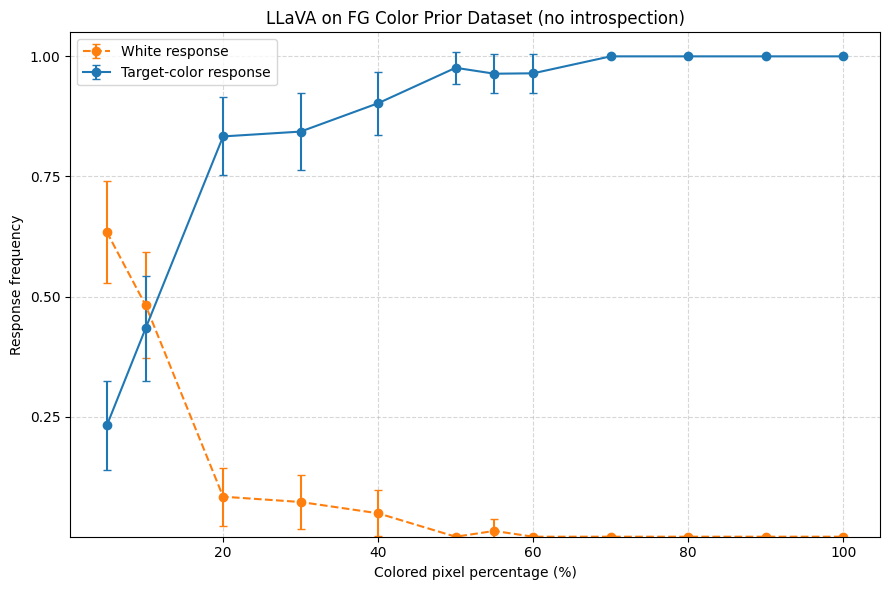

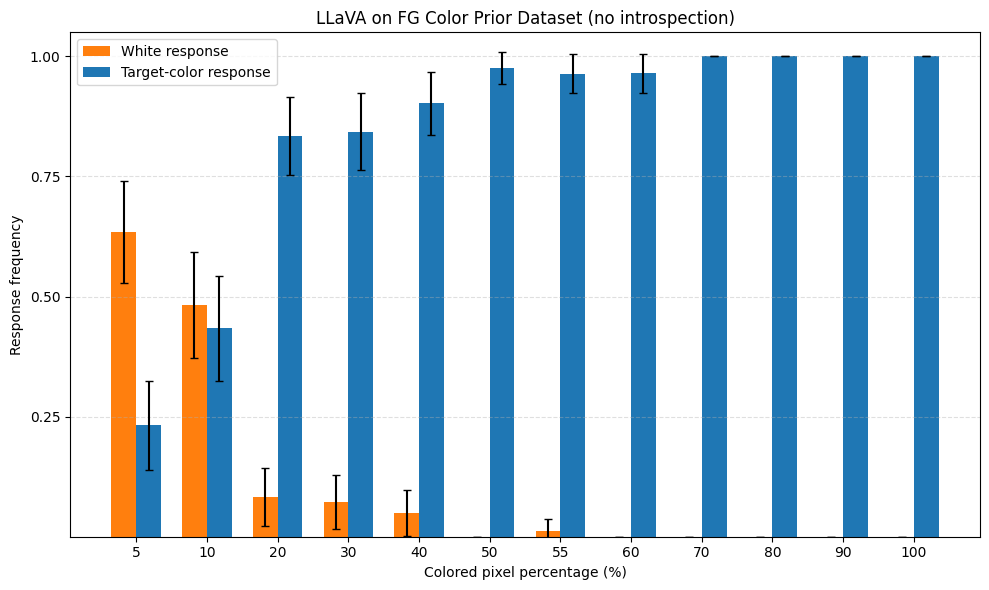

predicted_color
white              63
black              12
black and white     6
silver              1
Name: count, dtype: int64
predicted_color
brown              31
white              28
grey               12
red                11
green               8
orange              8
blue                8
yellow              5
purple              1
black               1
black and white     1
pink                1
Name: count, dtype: int64


In [13]:
plot_fg_response_frequencies_line(llava_prior_pred_df, title="LLaVA on FG Color Prior Dataset (no introspection)", response_col="predicted_color")
plot_fg_response_frequencies_bar(llava_prior_pred_df, title="LLaVA on FG Color Prior Dataset (no introspection)", response_col="predicted_color")
print(llava_prior_pred_df[llava_prior_pred_df["percent_colored"] == 0]["predicted_color"].value_counts())
print(llava_prior_pred_df[llava_prior_pred_df["percent_colored"] == 80]["predicted_color"].value_counts())

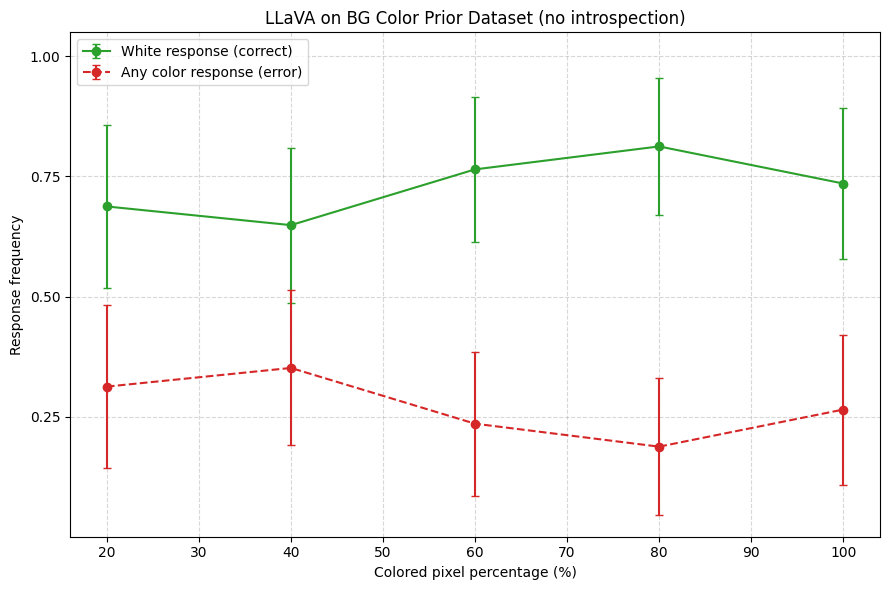

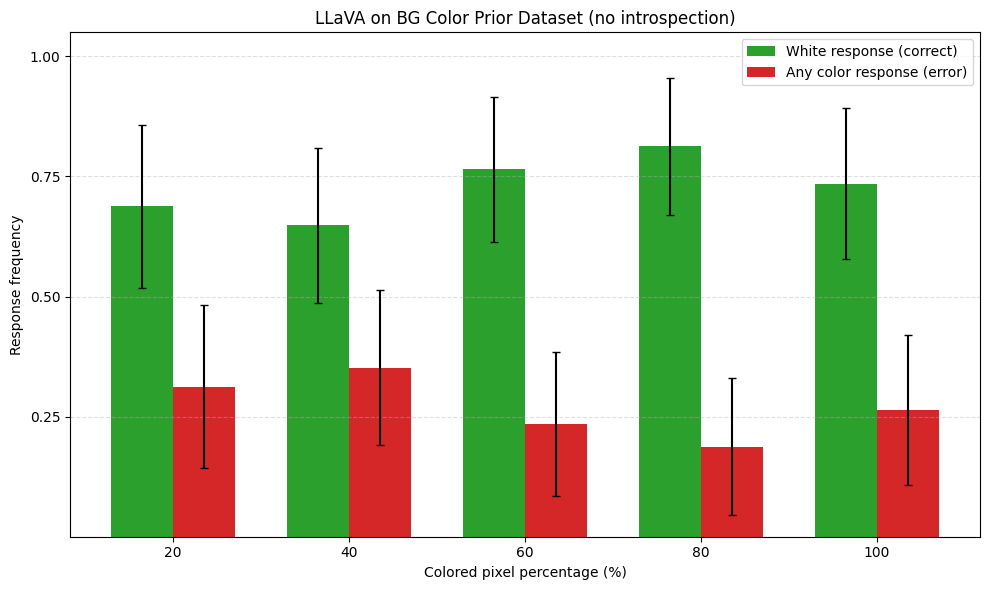

In [97]:
plot_bg_response_frequencies_line(llava_prior_pred_df, title="LLaVA on BG Color Prior Dataset (no introspection)", response_col="pred_color_this")
plot_bg_response_frequencies_bar(llava_prior_pred_df, title="LLaVA on BG Color Prior Dataset (no introspection)", response_col="pred_color_this")

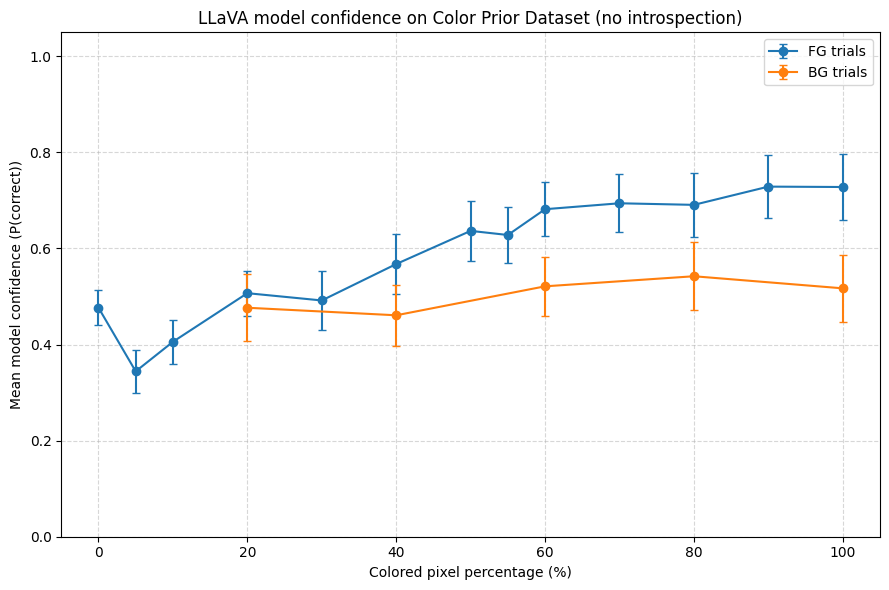

In [115]:
plot_model_confidence(
    llava_prior_pred_df,
    title="LLaVA model confidence on Color Prior Dataset (no introspection)",
)

## 1.2.2 Color Prior Dataset with Introspection Question (LLaVA-NeXT)

In [ ]:
suffix = "image_priors"
introsp_llava_prior_pred_df = evaluate_vlm_on_stimuli(
    prior_df,
    processor=llava_processor,
    model=llava_model,
    device=device,
    image_root=DATA,
    calibration_value=llava_threshold,
    desc="Evaluating canonical object colors (correct-prior stimuli)",
)

out_path = LLAVA / f"evaluation_introsp_{llava_model_name}_{suffix}.csv"
introsp_llava_prior_pred_df.to_csv(out_path, index=False)

In [98]:
introsp_llava_prior_pred_df = pd.read_csv(LLAVA / "evaluation_introsp_llava-v1.6-mistral-7b-hf_image_priors.csv")
introsp_llava_prior_pred_df = introsp_llava_prior_pred_df.merge(prior_df, on=["image_path", "object"])
display(introsp_llava_prior_pred_df)

,object,image_path,correct_answer,pred_color_this,prob_correct_this,calibration_threshold,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,cheese,/mnt/lustre/work/eickhoff/esx061/color-concept...,white,white,0.465088,50,correct_prior,yellow,white,BG,80,BG 80% (seq),seq
1,espresso maker,/mnt/lustre/work/eickhoff/esx061/color-concept...,red,red,0.427979,50,correct_prior,red,red,FG,5,FG 5% (seq),seq
2,tile roof,/mnt/lustre/work/eickhoff/esx061/color-concept...,red,red,0.957520,50,correct_prior,red,red,FG,100,FG 100% (seq),seq
3,cloud,/mnt/lustre/work/eickhoff/esx061/color-concept...,grey,grey,0.004292,50,correct_prior,grey,grey,FG,55,FG 55% (seq),seq
4,frilled lizard,/mnt/lustre/work/eickhoff/esx061/color-concept...,brown,brown,0.724609,50,correct_prior,brown,brown,FG,100,FG 100% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,eggplant,/mnt/lustre/work/eickhoff/esx061/color-concept...,purple,purple,0.857910,50,correct_prior,purple,purple,FG,40,FG 40% (seq),seq
1256,rattlesnake,/mnt/lustre/work/eickhoff/esx061/color-concept...,white,black and white,0.364502,50,correct_prior,brown,white,FG,0,FG 0% (seq),seq
1257,tow truck,/mnt/lustre/work/eickhoff/esx061/color-concept...,brown,brown,0.838867,50,correct_prior,brown,brown,FG,40,FG 40% (seq),seq
1258,snake,/mnt/lustre/work/eickhoff/esx061/color-concept...,green,green,0.905273,50,correct_prior,green,green,FG,50,FG 50% (seq),seq


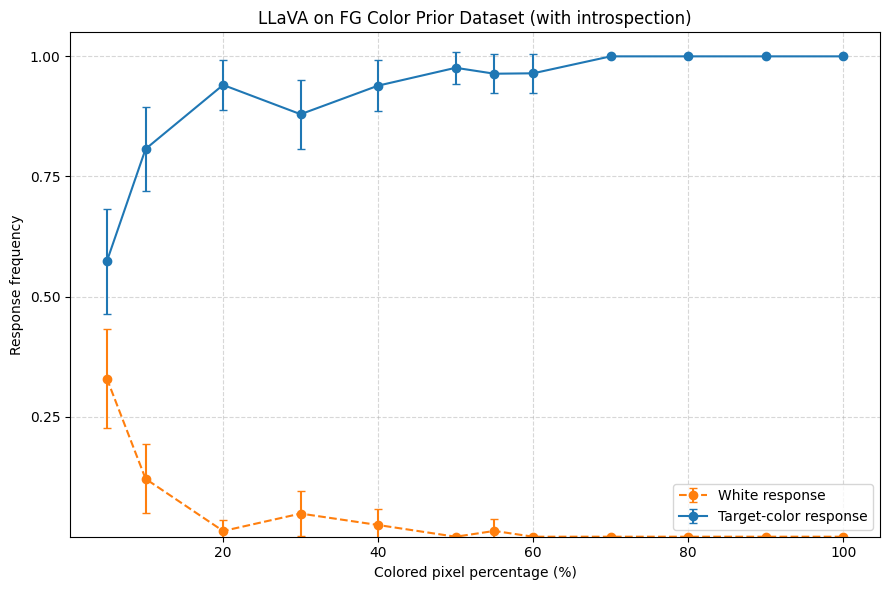

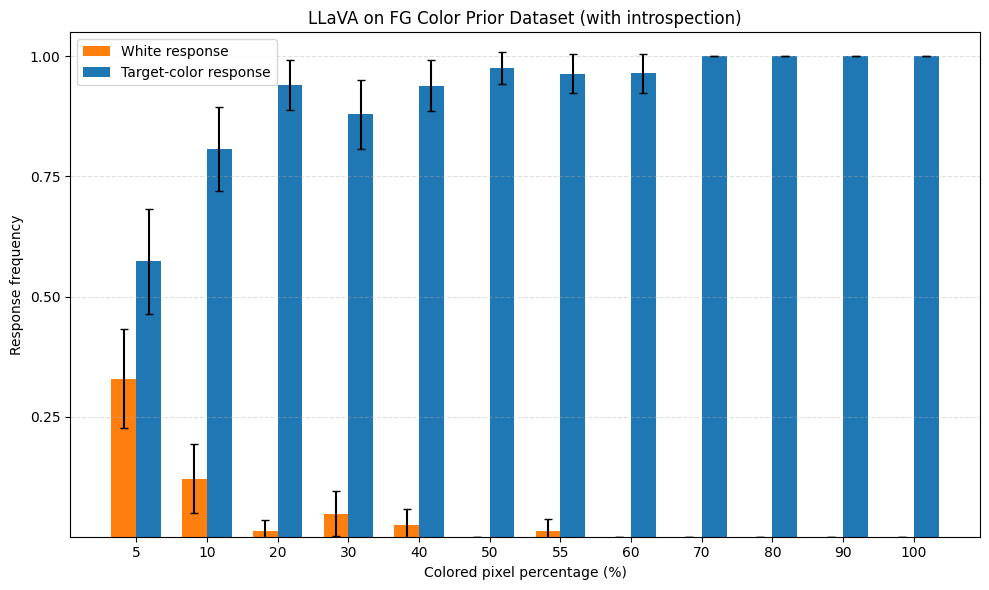

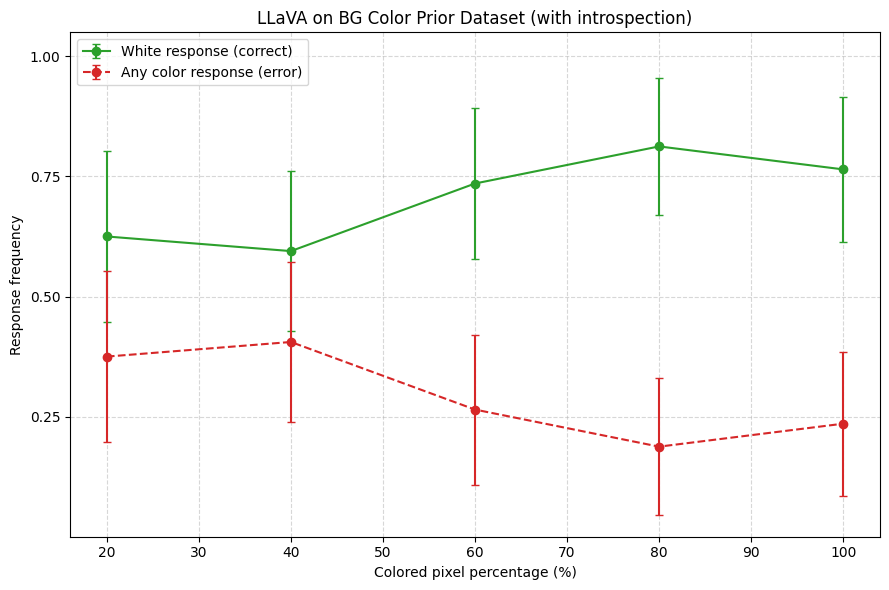

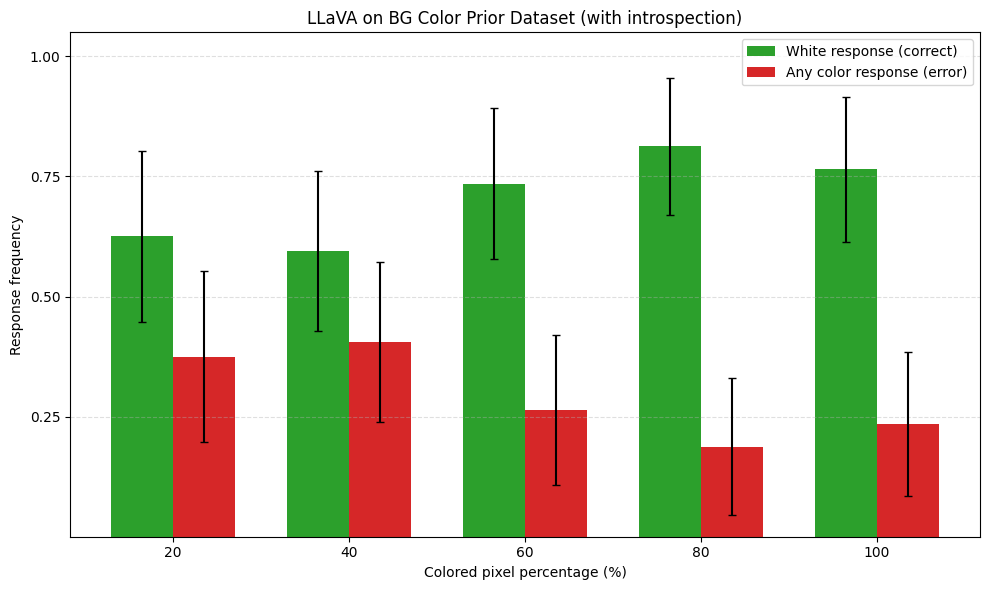

In [99]:
plot_fg_response_frequencies_line(introsp_llava_prior_pred_df, title="LLaVA on FG Color Prior Dataset (with introspection)", response_col="pred_color_this")
plot_fg_response_frequencies_bar(introsp_llava_prior_pred_df, title="LLaVA on FG Color Prior Dataset (with introspection)", response_col="pred_color_this")

plot_bg_response_frequencies_line(introsp_llava_prior_pred_df, title="LLaVA on BG Color Prior Dataset (with introspection)", response_col="pred_color_this")
plot_bg_response_frequencies_bar(introsp_llava_prior_pred_df, title="LLaVA on BG Color Prior Dataset (with introspection)", response_col="pred_color_this")

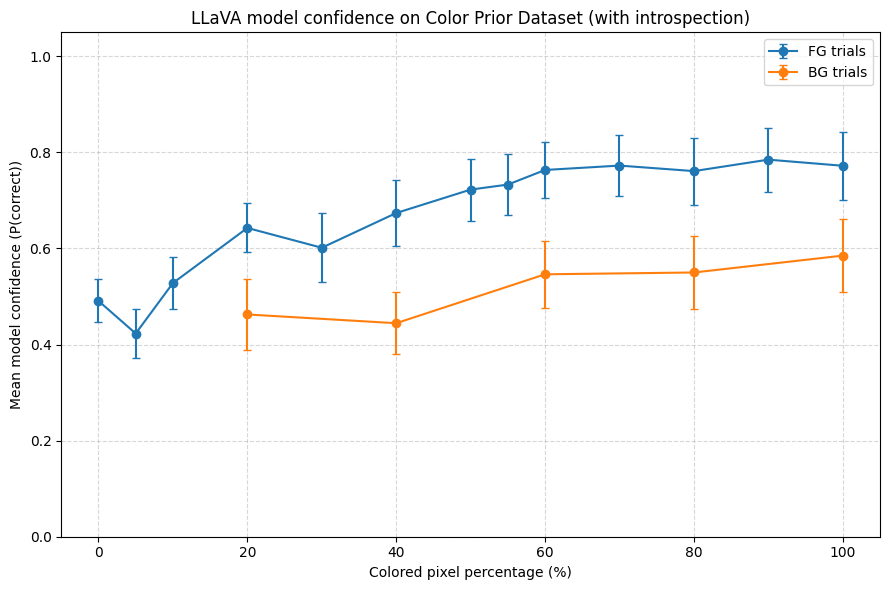

In [114]:
plot_model_confidence(
    introsp_llava_prior_pred_df,
    title="LLaVA model confidence on Color Prior Dataset (with introspection)",
)


## 1.3.1. Counterfact Color Dataset (LLaVA-NeXT)

In [15]:
suffix = "counterfact"
llava_cf_pred_df = evaluate_vlm_on_stimuli(
    counterfact_df,
    processor=llava_processor,
    model=llava_model,
    device=device,
    image_root=DATA,
    desc="Evaluating counterfact object colors (counterfact stimuli)",
)

out_path = LLAVA / f"evaluation_{llava_model_name}_{suffix}.csv"
llava_cf_pred_df.to_csv(out_path, index=False)

Evaluating counterfact object colors (counterfact stimuli):   1%|          | 4/412 [00:09<15:52,  2.33s/it]


KeyboardInterrupt: 

In [14]:
llava_cf_pred_df = pd.read_csv(LLAVA / "evaluation_llava-v1.6-mistral-7b-hf_counterfact.csv")
llava_cf_pred_df = llava_cf_pred_df.merge(counterfact_df, on=["image_path", "object"])
display(llava_cf_pred_df)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/LLaVA-NeXT_results/evaluation_llava-v1.6-mistral-7b-hf_counterfact.csv'

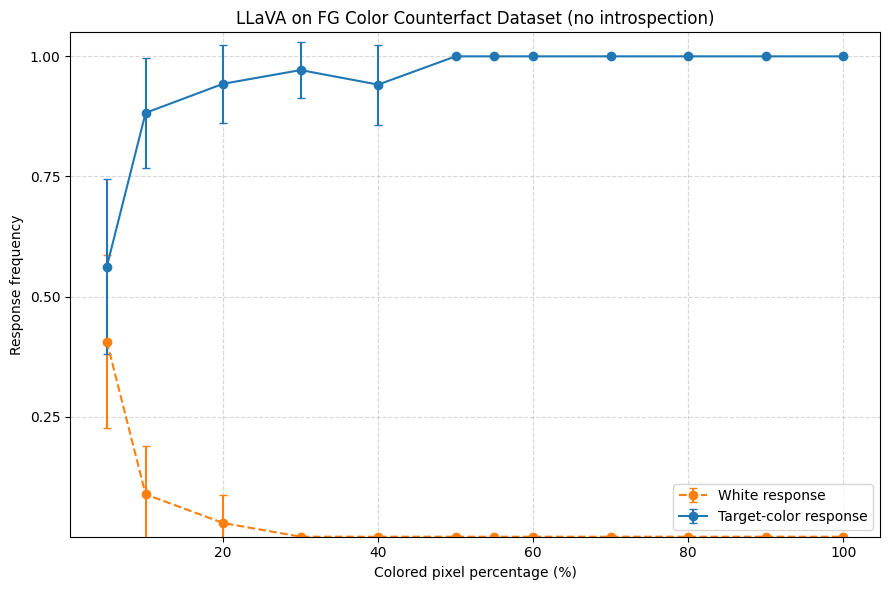

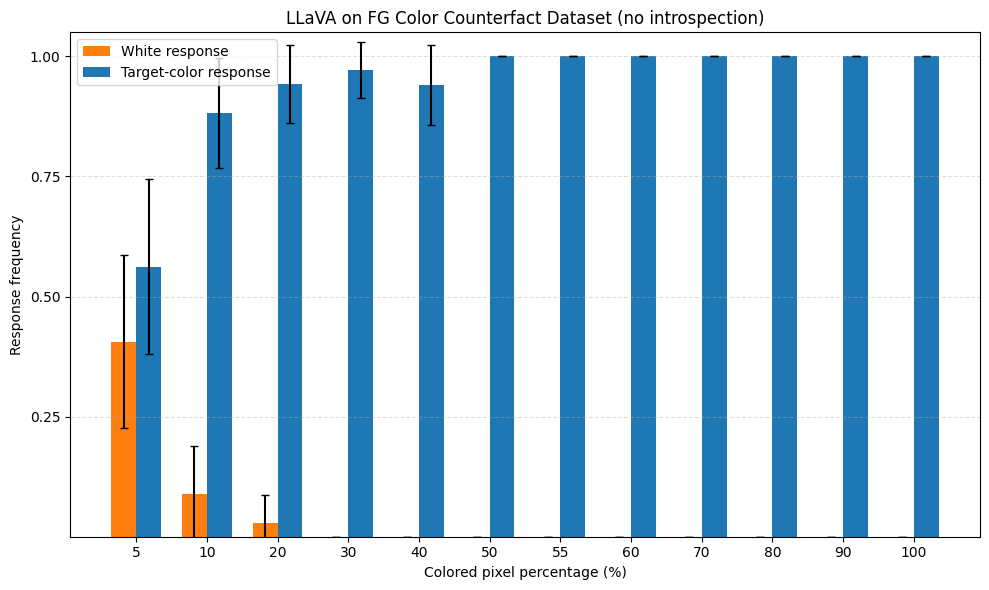

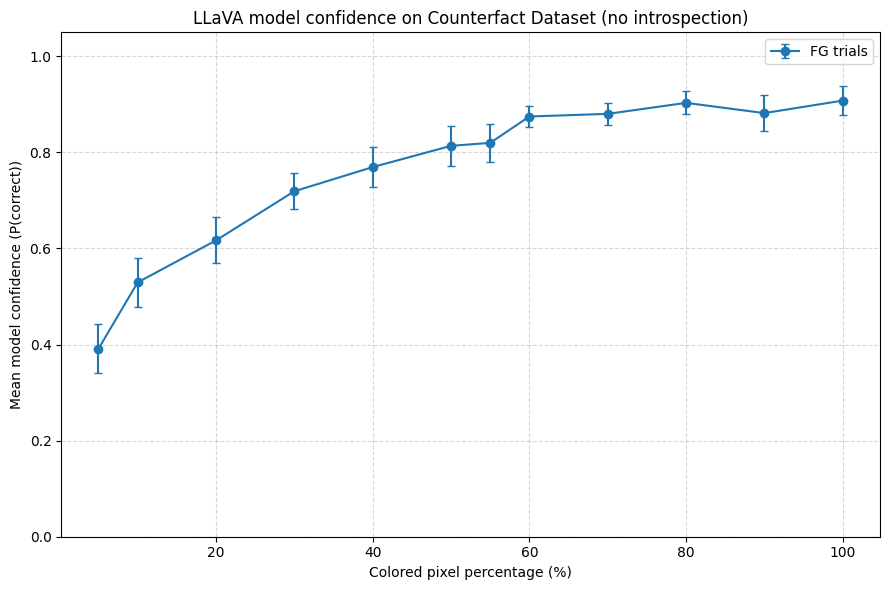

In [117]:
plot_fg_response_frequencies_line(llava_cf_pred_df, title="LLaVA on FG Color Counterfact Dataset (no introspection)", response_col="pred_color_this")
plot_fg_response_frequencies_bar(llava_cf_pred_df, title="LLaVA on FG Color Counterfact Dataset (no introspection)", response_col="pred_color_this")

plot_model_confidence(
    llava_cf_pred_df,
    title="LLaVA model confidence on Counterfact Dataset (no introspection)",
)

## 1.3.2. Counterfact Color Dataset with Introspection Question (LLaVA-NeXT)

In [ ]:
suffix = "counterfact"
introsp_llava_cf_pred_df = evaluate_vlm_on_stimuli(
    counterfact_df,
    processor=llava_processor,
    model=llava_model,
    device=device,
    image_root=DATA,
    calibration_value=llava_threshold,
    desc="Evaluating counterfact object colors (counterfact stimuli)",
)

out_path = LLAVA / f"evaluation_introsp_{llava_model_name}_{suffix}.csv"
introsp_llava_cf_pred_df.to_csv(out_path, index=False)

In [122]:
introsp_llava_cf_pred_df = pd.read_csv(LLAVA / "evaluation_introsp_llava-v1.6-mistral-7b-hf_counterfact.csv")
introsp_llava_cf_pred_df = introsp_llava_cf_pred_df.merge(counterfact_df, on=["image_path", "object"])
display(introsp_llava_cf_pred_df)

,object,image_path,correct_answer,pred_color_this,prob_correct_this,calibration_threshold,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,rose,/mnt/lustre/work/eickhoff/esx061/color-concept...,blue,blue,0.981445,50,counterfact,blue,blue,FG,100,FG 100% (seq),seq
1,sealyham terrier,/mnt/lustre/work/eickhoff/esx061/color-concept...,purple,purple,0.937500,50,counterfact,purple,purple,FG,60,FG 60% (seq),seq
2,iguana,/mnt/lustre/work/eickhoff/esx061/color-concept...,orange,orange,0.694824,50,counterfact,orange,orange,FG,10,FG 10% (seq),seq
3,hartebeest,/mnt/lustre/work/eickhoff/esx061/color-concept...,red,red,0.637207,50,counterfact,red,red,FG,55,FG 55% (seq),seq
4,mouse,/mnt/lustre/work/eickhoff/esx061/color-concept...,red,white,0.210327,50,counterfact,red,red,FG,20,FG 20% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,trailer truck,/mnt/lustre/work/eickhoff/esx061/color-concept...,orange,orange,0.891113,50,counterfact,orange,orange,FG,40,FG 40% (seq),seq
408,frilled lizard,/mnt/lustre/work/eickhoff/esx061/color-concept...,pink,pink,0.393555,50,counterfact,pink,pink,FG,10,FG 10% (seq),seq
409,coho,/mnt/lustre/work/eickhoff/esx061/color-concept...,purple,purple,0.742676,50,counterfact,purple,purple,FG,30,FG 30% (seq),seq
410,butternut squash,/mnt/lustre/work/eickhoff/esx061/color-concept...,green,green,0.923828,50,counterfact,green,green,FG,70,FG 70% (seq),seq


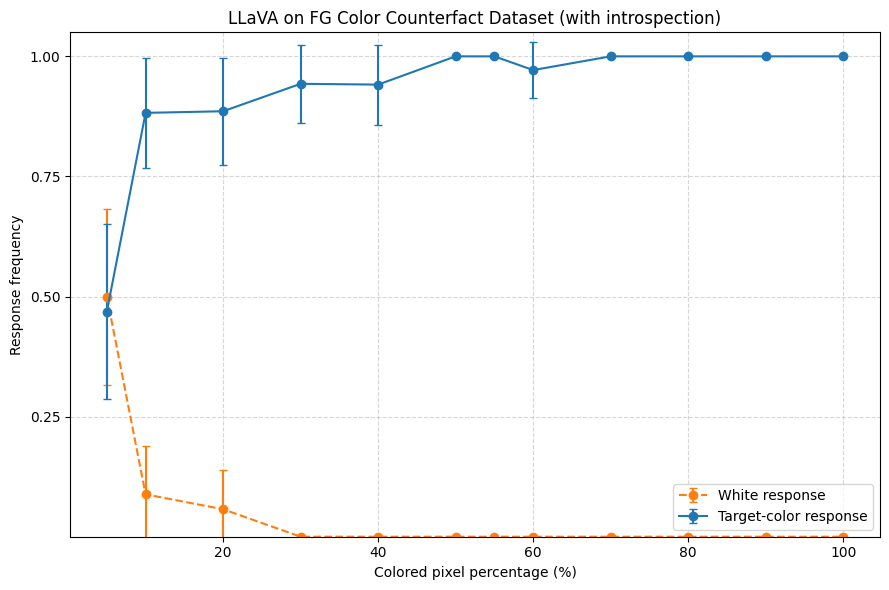

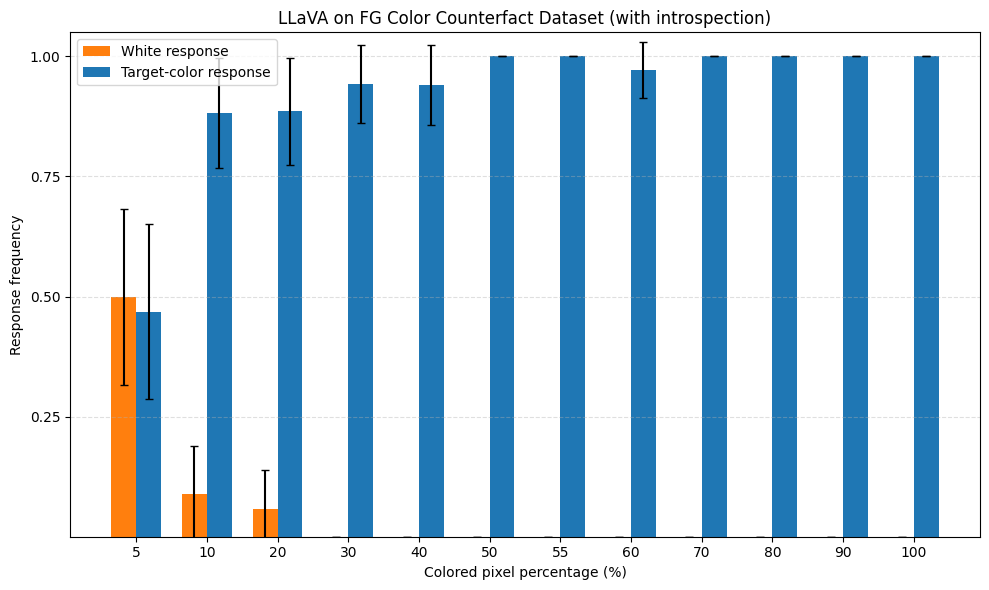

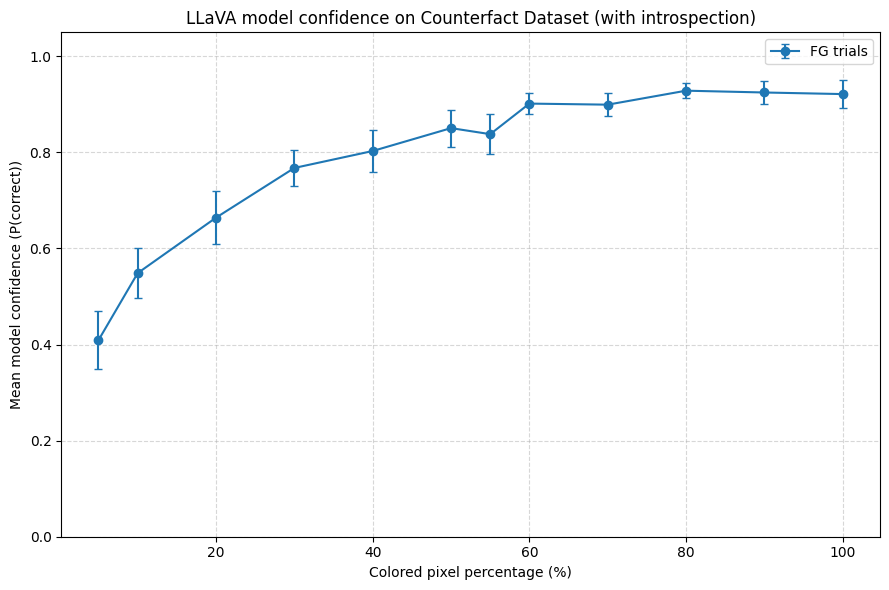

In [120]:
plot_fg_response_frequencies_line(introsp_llava_cf_pred_df, title="LLaVA on FG Color Counterfact Dataset (with introspection)", response_col="pred_color_this")
plot_fg_response_frequencies_bar(introsp_llava_cf_pred_df, title="LLaVA on FG Color Counterfact Dataset (with introspection)", response_col="pred_color_this")

plot_model_confidence(
    introsp_llava_cf_pred_df,
    title="LLaVA model confidence on Counterfact Dataset (with introspection)",
)

## 1.4.1. Shape Dataset (LLaVA-NeXT)

In [ ]:
suffix = "shapes"
llava_shape_pred_df = evaluate_vlm_on_stimuli(
    shape_df,
    processor=llava_processor,
    model=llava_model,
    device=device,
    image_root=DATA,
    desc="Evaluating shapes",
)

out_path = LLAVA / f"evaluation_{llava_model_name}_{suffix}.csv"
llava_shape_pred_df.to_csv(out_path, index=False)

In [124]:
llava_shape_pred_df = pd.read_csv(LLAVA / "evaluation_llava-v1.6-mistral-7b-hf_shapes_old.csv")
llava_shape_pred_df = llava_shape_pred_df.merge(shape_df, on=["image_path", "object"])
display(llava_shape_pred_df)

,object,image_path,correct_answer,pred_color_this,prob_correct_this,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,hexagon,/mnt/lustre/work/eickhoff/esx061/color-concept...,yellow,yellow,0.847656,shape,yellow,yellow,FG,60,FG 60% (seq),seq
1,pentagon,/mnt/lustre/work/eickhoff/esx061/color-concept...,purple,purple,0.885254,shape,purple,purple,FG,55,FG 55% (seq),seq
2,square,/mnt/lustre/work/eickhoff/esx061/color-concept...,blue,blue,0.454346,shape,blue,blue,FG,5,FG 5% (seq),seq
3,triangle,/mnt/lustre/work/eickhoff/esx061/color-concept...,brown,brown,0.634277,shape,brown,brown,FG,50,FG 50% (seq),seq
4,pentagon,/mnt/lustre/work/eickhoff/esx061/color-concept...,orange,orange,0.816895,shape,orange,orange,FG,90,FG 90% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...
1326,circle,/mnt/lustre/work/eickhoff/esx061/color-concept...,grey,grey,0.003328,shape,grey,grey,FG,40,FG 40% (seq),seq
1327,hexagon,/mnt/lustre/work/eickhoff/esx061/color-concept...,brown,brown,0.655762,shape,brown,brown,FG,70,FG 70% (seq),seq
1328,triangle,/mnt/lustre/work/eickhoff/esx061/color-concept...,white,black,0.286865,shape,blue,white,FG,0,FG 0% (seq),seq
1329,triangle,/mnt/lustre/work/eickhoff/esx061/color-concept...,red,white,0.108643,shape,red,white,BG,40,BG 40% (seq),seq


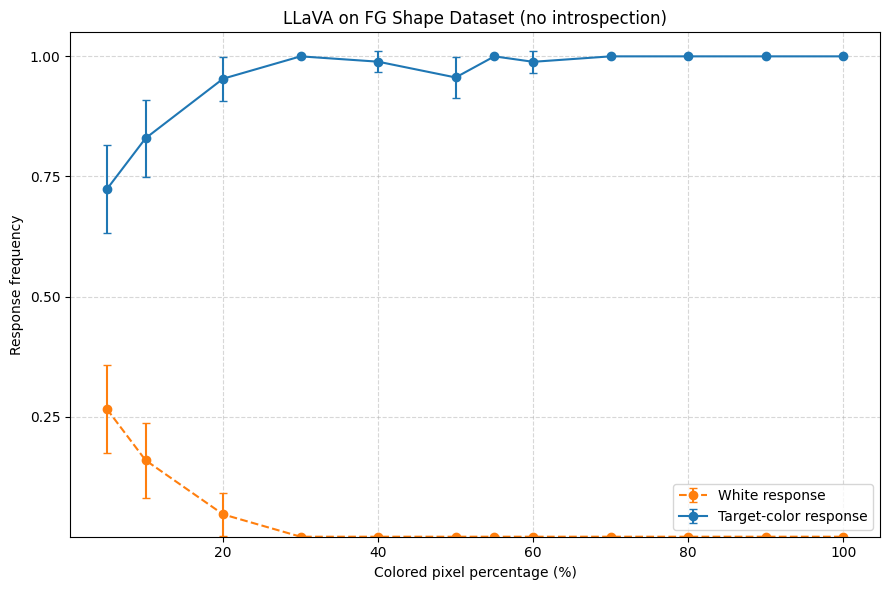

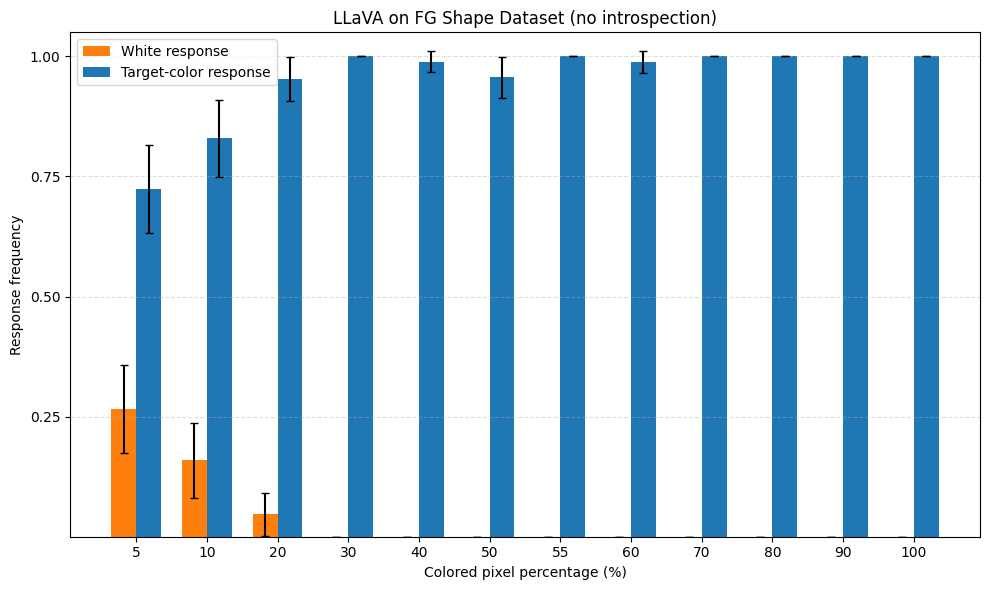

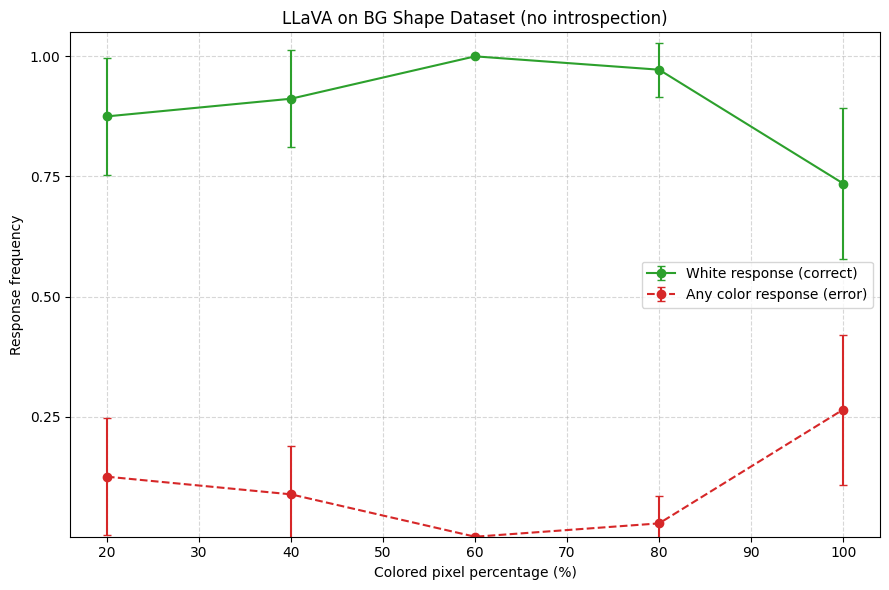

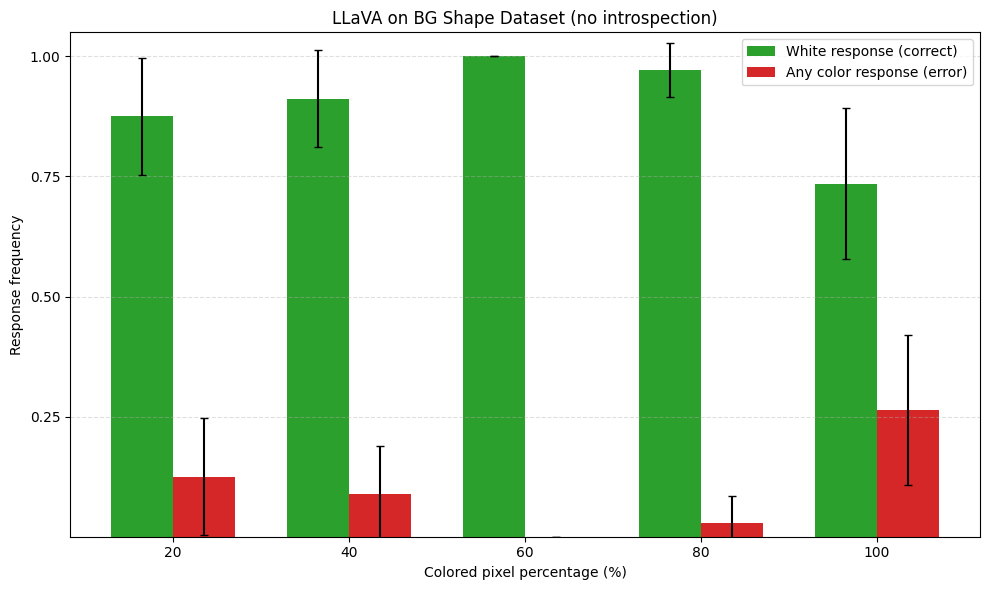

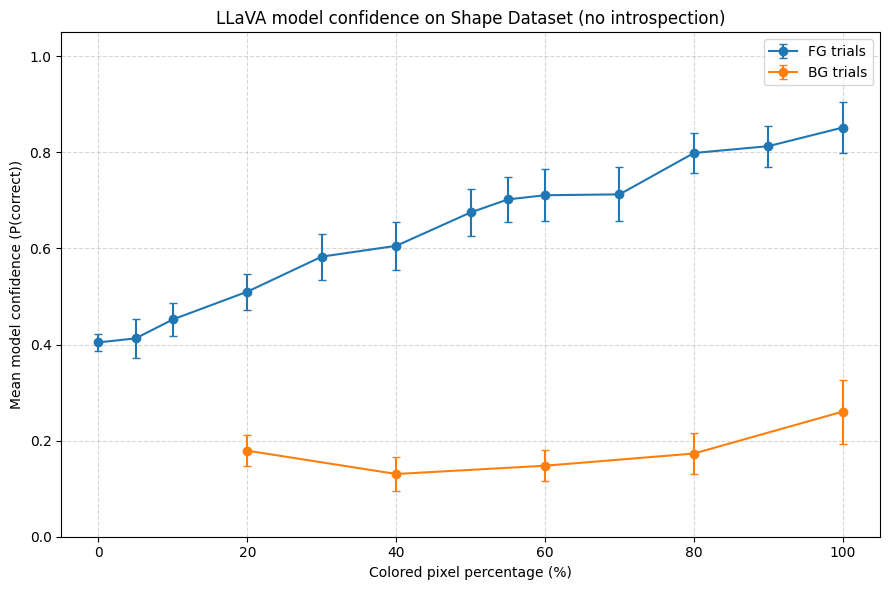

In [127]:
plot_fg_response_frequencies_line(llava_shape_pred_df, title="LLaVA on FG Shape Dataset (no introspection)", response_col="pred_color_this")
plot_fg_response_frequencies_bar(llava_shape_pred_df, title="LLaVA on FG Shape Dataset (no introspection)", response_col="pred_color_this")

plot_bg_response_frequencies_line(llava_shape_pred_df, title="LLaVA on BG Shape Dataset (no introspection)", response_col="pred_color_this")
plot_bg_response_frequencies_bar(llava_shape_pred_df, title="LLaVA on BG Shape Dataset (no introspection)", response_col="pred_color_this")
plot_model_confidence(
    llava_shape_pred_df,
    title="LLaVA model confidence on Shape Dataset (no introspection)",
)

## 1.4.2. Shape Dataset with Introspection (LLaVA-NeXT)

In [ ]:
suffix = "shapes"
introsp_llava_shape_pred_df = evaluate_vlm_on_stimuli(
    shape_df,
    processor=llava_processor,
    model=llava_model,
    device=device,
    image_root=DATA,
    desc="Evaluating shapes",
    calibration_value=llava_threshold,
)

out_path = LLAVA / f"evaluation_introsp_{llava_model_name}_{suffix}.csv"
introsp_llava_shape_pred_df.to_csv(out_path, index=False)

In [128]:
introsp_llava_shape_pred_df = pd.read_csv(LLAVA / "evaluation_introsp_llava-v1.6-mistral-7b-hf_shapes.csv")
introsp_llava_shape_pred_df = introsp_llava_shape_pred_df.merge(shape_df, on=["image_path", "object"])
display(introsp_llava_shape_pred_df)

,object,image_path,correct_answer,pred_color_this,prob_correct_this,calibration_threshold,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,hexagon,/mnt/lustre/work/eickhoff/esx061/color-concept...,yellow,yellow,0.917480,50,shape,yellow,yellow,FG,60,FG 60% (seq),seq
1,pentagon,/mnt/lustre/work/eickhoff/esx061/color-concept...,purple,purple,0.895996,50,shape,purple,purple,FG,55,FG 55% (seq),seq
2,square,/mnt/lustre/work/eickhoff/esx061/color-concept...,blue,blue,0.515137,50,shape,blue,blue,FG,5,FG 5% (seq),seq
3,triangle,/mnt/lustre/work/eickhoff/esx061/color-concept...,brown,brown,0.857910,50,shape,brown,brown,FG,50,FG 50% (seq),seq
4,pentagon,/mnt/lustre/work/eickhoff/esx061/color-concept...,orange,orange,0.816895,50,shape,orange,orange,FG,90,FG 90% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,circle,/mnt/lustre/work/eickhoff/esx061/color-concept...,grey,grey,0.003590,50,shape,grey,grey,FG,40,FG 40% (seq),seq
1327,hexagon,/mnt/lustre/work/eickhoff/esx061/color-concept...,brown,brown,0.908691,50,shape,brown,brown,FG,70,FG 70% (seq),seq
1328,triangle,/mnt/lustre/work/eickhoff/esx061/color-concept...,white,black,0.289551,50,shape,blue,white,FG,0,FG 0% (seq),seq
1329,triangle,/mnt/lustre/work/eickhoff/esx061/color-concept...,white,white,0.653320,50,shape,red,white,BG,40,BG 40% (seq),seq


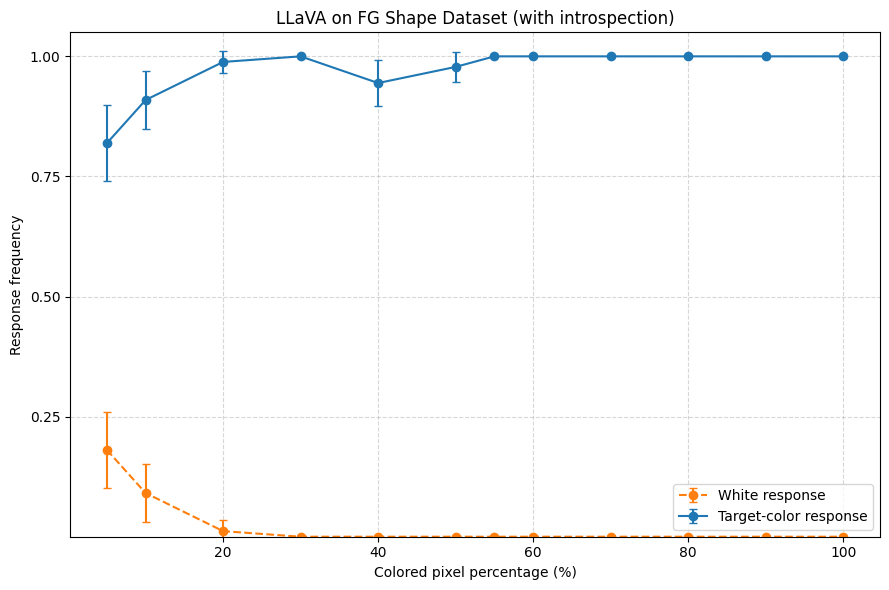

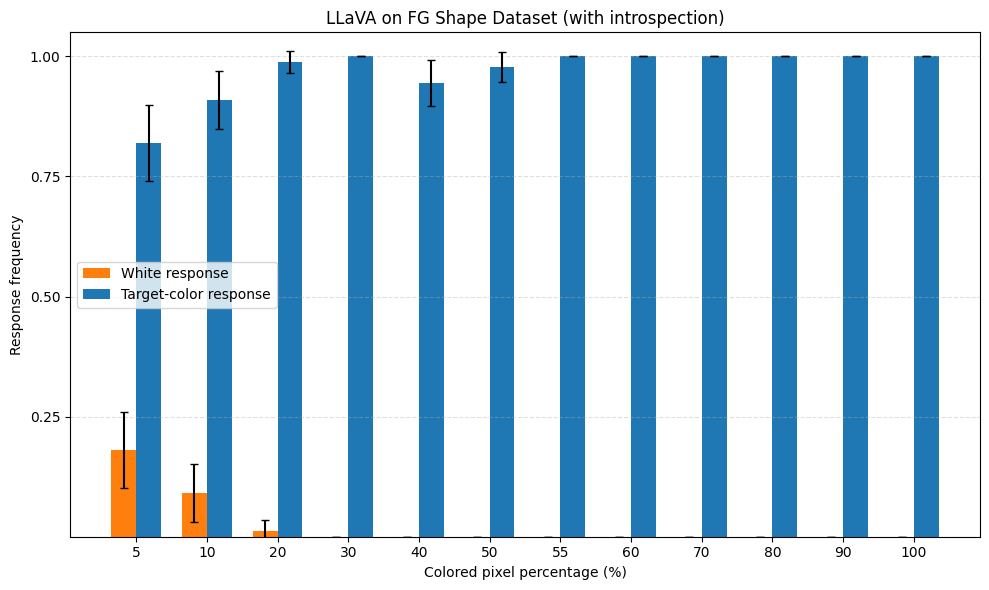

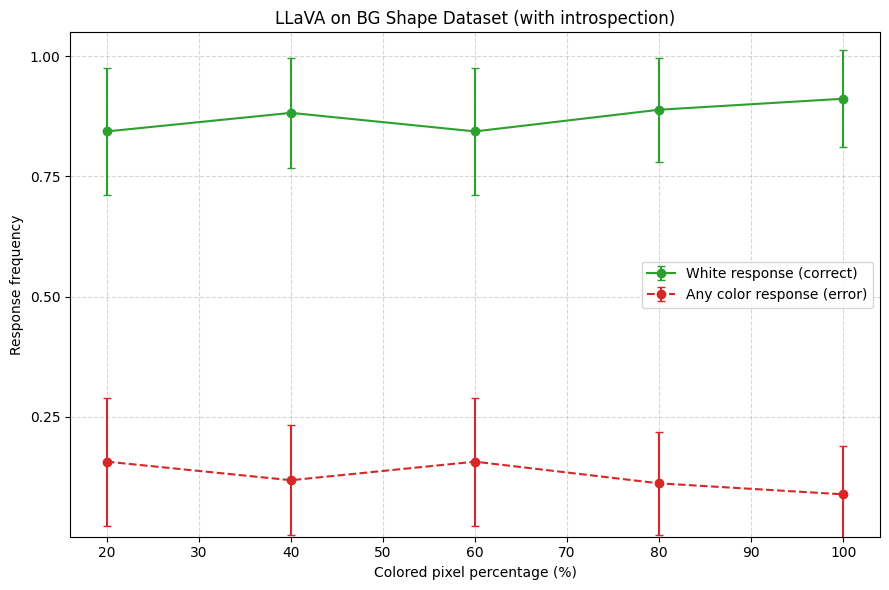

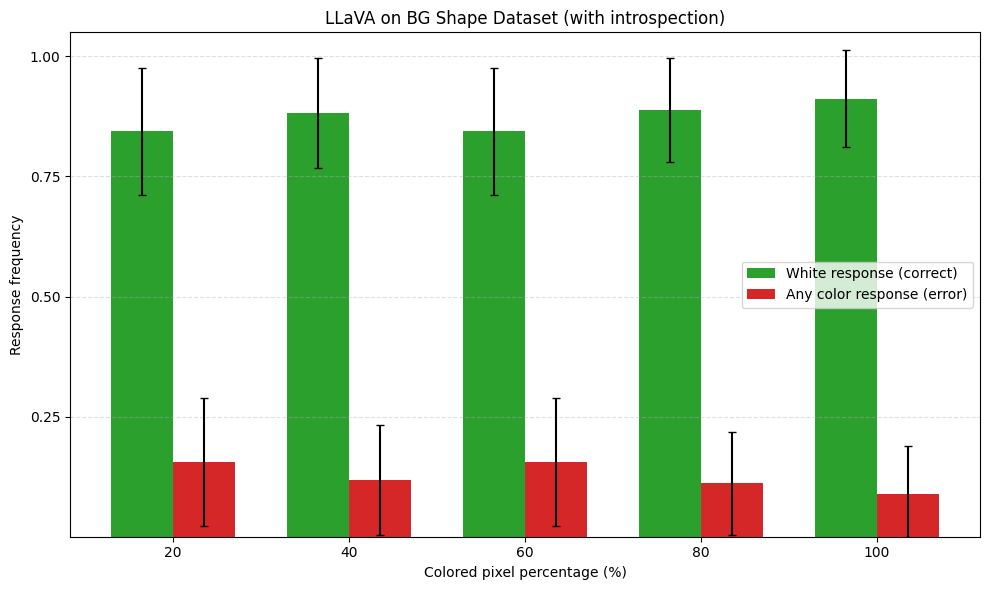

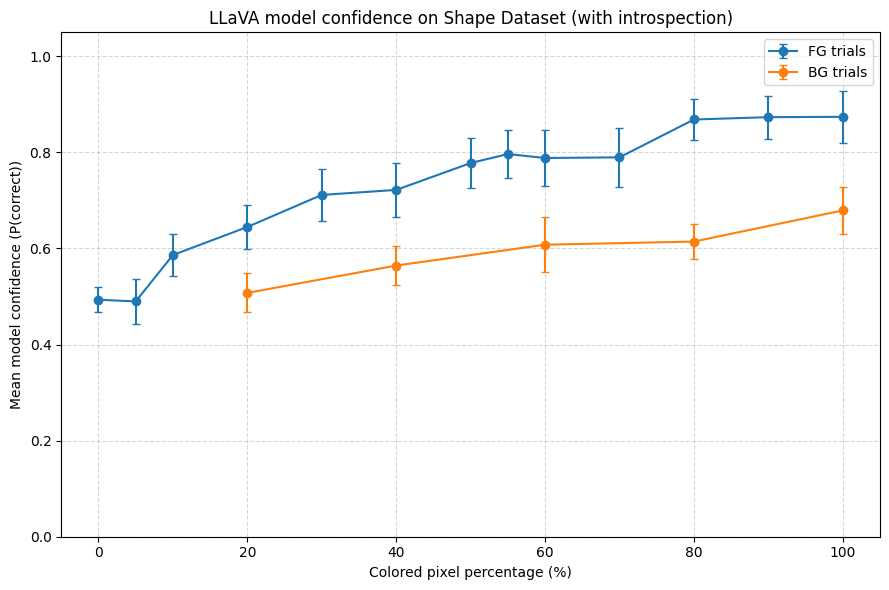

In [129]:
plot_fg_response_frequencies_line(introsp_llava_shape_pred_df, title="LLaVA on FG Shape Dataset (with introspection)", response_col="pred_color_this")
plot_fg_response_frequencies_bar(introsp_llava_shape_pred_df, title="LLaVA on FG Shape Dataset (with introspection)", response_col="pred_color_this")

plot_bg_response_frequencies_line(introsp_llava_shape_pred_df, title="LLaVA on BG Shape Dataset (with introspection)", response_col="pred_color_this")
plot_bg_response_frequencies_bar(introsp_llava_shape_pred_df, title="LLaVA on BG Shape Dataset (with introspection)", response_col="pred_color_this")
plot_model_confidence(
    introsp_llava_shape_pred_df,
    title="LLaVA model confidence on Shape Dataset (with introspection)",
)

# 2. GPT-5o

In [18]:
gpt_model_name = "gpt-5.2"
GPT = DATA / "GPT_results"
GPT.mkdir(parents=True, exist_ok=True)

## 2.1. Introspection question (GPT-4o)

In [24]:
calibration = ask_vlm_introspection_threshold(
    backend="gpt",
    model_name=gpt_model_name,
)

gpt_threshold = calibration["introspection_threshold"]
gpt_raw = calibration["introspection_raw"]
print(gpt_raw)
print(gpt_threshold)

60
60


## 2.2. Color Prior Dataset (GPT-4o)

In [25]:
suffix = "image_priors"
gpt_prior_pred_df = evaluate_vlm_on_stimuli_old(
    prior_df.head(),
    backend="gpt52",
    model_name=gpt_model_name,
    image_root=DATA,
    device=None,   # ignored for GPT
)
print(gpt_prior_pred_df)
out_path = GPT / f"evaluation_{gpt_model_name}_{suffix}.csv"
gpt_prior_pred_df.to_csv(out_path, index=False)

Evaluating stimuli:   0%|          | 0/5 [00:00<?, ?it/s]


TypeError: Responses.create() got an unexpected keyword argument 'output'

,object,image_path,correct_answer,pred_color_this,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,cheese,/mnt/lustre/work/eickhoff/esx061/color-concept...,yellow,yellow,correct_prior,yellow,white,BG,80,BG 80% (seq),seq
1,espresso maker,/mnt/lustre/work/eickhoff/esx061/color-concept...,red,black,correct_prior,red,red,FG,5,FG 5% (seq),seq
2,tile roof,/mnt/lustre/work/eickhoff/esx061/color-concept...,red,red,correct_prior,red,red,FG,100,FG 100% (seq),seq
3,cloud,/mnt/lustre/work/eickhoff/esx061/color-concept...,grey,grey,correct_prior,grey,grey,FG,55,FG 55% (seq),seq
4,frilled lizard,/mnt/lustre/work/eickhoff/esx061/color-concept...,brown,brown,correct_prior,brown,brown,FG,100,FG 100% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...
1255,eggplant,/mnt/lustre/work/eickhoff/esx061/color-concept...,purple,purple,correct_prior,purple,purple,FG,40,FG 40% (seq),seq
1256,rattlesnake,/mnt/lustre/work/eickhoff/esx061/color-concept...,white,black,correct_prior,brown,white,FG,0,FG 0% (seq),seq
1257,tow truck,/mnt/lustre/work/eickhoff/esx061/color-concept...,brown,brown,correct_prior,brown,brown,FG,40,FG 40% (seq),seq
1258,snake,/mnt/lustre/work/eickhoff/esx061/color-concept...,green,green,correct_prior,green,green,FG,50,FG 50% (seq),seq


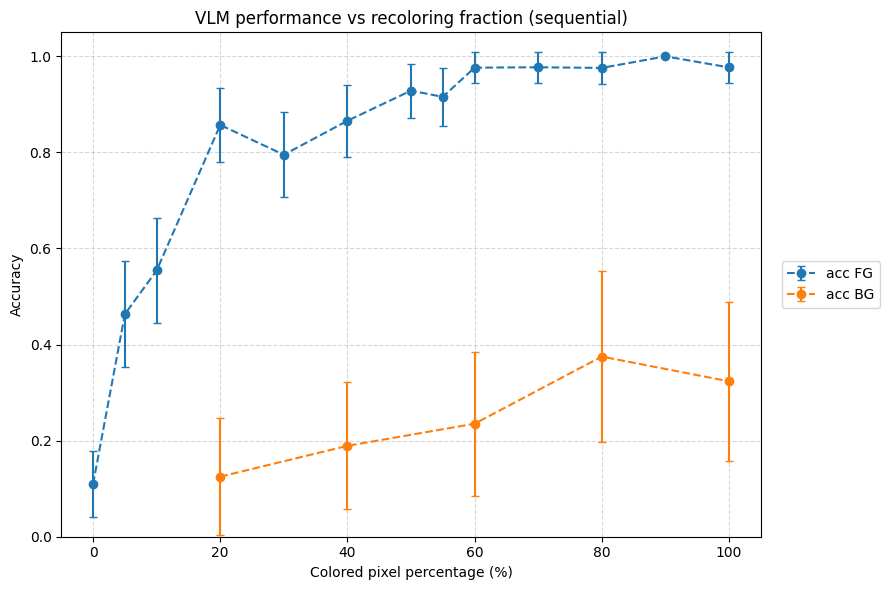

In [ ]:
gpt_prior_pred_df = pd.read_csv(GPT / "evaluation_gpt-4o_image_priors.csv")
gpt_prior_pred_df = gpt_prior_pred_df.merge(prior_df, on=["image_path", "object"])
display(gpt_prior_pred_df)
plot_vlm_prolific(gpt_prior_pred_df, ci=True)

## 2.3. Counterfact Color Dataset (GPT-4o)

In [ ]:
suffix = "counterfact"
gpt_cf_pred_df = evaluate_vlm_on_stimuli(
    counterfact_df,
    backend="gpt",
    model_name="gpt-4o",
    image_root=DATA,
    device=None,   # ignored for GPT
)

out_path = GPT / f"evaluation_shapes_{gpt_model_name}_{suffix}.csv"
gpt_cf_pred_df.to_csv(out_path, index=False)

Evaluating stimuli: 100%|██████████| 412/412 [06:40<00:00,  1.03it/s]


,object,image_path,correct_answer,pred_color_this,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,rose,/mnt/lustre/work/eickhoff/esx061/color-concept...,blue,blue,counterfact,blue,blue,FG,100,FG 100% (seq),seq
1,sealyham terrier,/mnt/lustre/work/eickhoff/esx061/color-concept...,purple,purple,counterfact,purple,purple,FG,60,FG 60% (seq),seq
2,iguana,/mnt/lustre/work/eickhoff/esx061/color-concept...,orange,orange,counterfact,orange,orange,FG,10,FG 10% (seq),seq
3,hartebeest,/mnt/lustre/work/eickhoff/esx061/color-concept...,red,red,counterfact,red,red,FG,55,FG 55% (seq),seq
4,mouse,/mnt/lustre/work/eickhoff/esx061/color-concept...,red,black,counterfact,red,red,FG,20,FG 20% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...
407,trailer truck,/mnt/lustre/work/eickhoff/esx061/color-concept...,orange,orange,counterfact,orange,orange,FG,40,FG 40% (seq),seq
408,frilled lizard,/mnt/lustre/work/eickhoff/esx061/color-concept...,pink,black,counterfact,pink,pink,FG,10,FG 10% (seq),seq
409,coho,/mnt/lustre/work/eickhoff/esx061/color-concept...,purple,purple,counterfact,purple,purple,FG,30,FG 30% (seq),seq
410,butternut squash,/mnt/lustre/work/eickhoff/esx061/color-concept...,green,green,counterfact,green,green,FG,70,FG 70% (seq),seq


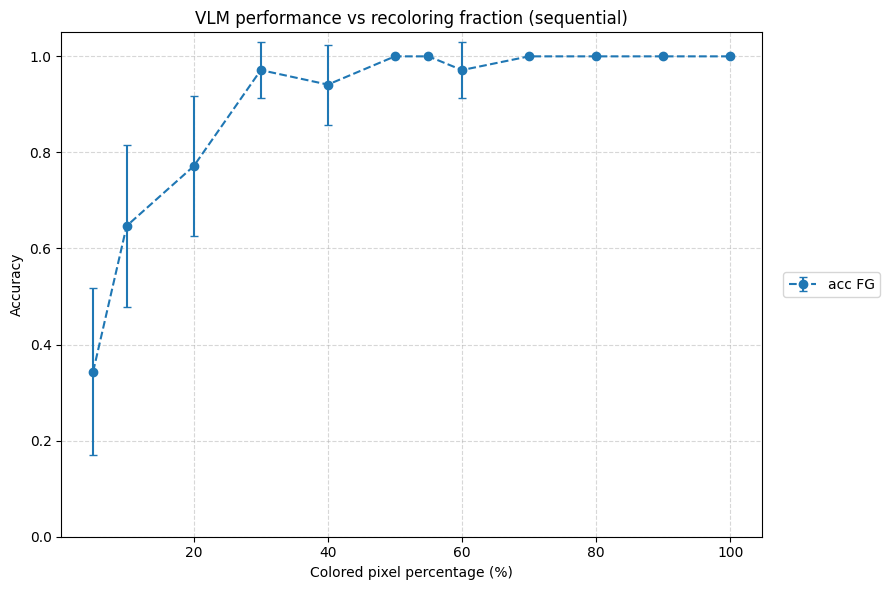

In [ ]:
gpt_cf_pred_df = pd.read_csv(GPT / "evaluation_gpt-4o_counterfact.csv")
gpt_cf_pred_df = gpt_cf_pred_df.merge(counterfact_df, on=["image_path", "object"])
display(gpt_cf_pred_df)
plot_vlm_prolific(gpt_cf_pred_df, ci=True)

## 2.4. Shape Dataset (GPT-4o)

In [ ]:
suffix = "shapes"
gpt_shape_pred_df = evaluate_vlm_on_stimuli(
    shape_df,
    backend="gpt",
    model_name="gpt-4o",
    image_root=DATA,
    device=None,   # ignored for GPT
)

out_path = GPT / f"evaluation_shapes_{gpt_model_name}_{suffix}.csv"
gpt_shape_pred_df.to_csv(out_path, index=False)

Evaluating stimuli: 100%|██████████| 1331/1331 [19:37<00:00,  1.13it/s]


,object,image_path,correct_answer,pred_color_this,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,hexagon,/mnt/lustre/work/eickhoff/esx061/color-concept...,yellow,yellow,shape,yellow,yellow,FG,60,FG 60% (seq),seq
1,pentagon,/mnt/lustre/work/eickhoff/esx061/color-concept...,purple,purple,shape,purple,purple,FG,55,FG 55% (seq),seq
2,square,/mnt/lustre/work/eickhoff/esx061/color-concept...,blue,white,shape,blue,blue,FG,5,FG 5% (seq),seq
3,triangle,/mnt/lustre/work/eickhoff/esx061/color-concept...,brown,brown,shape,brown,brown,FG,50,FG 50% (seq),seq
4,pentagon,/mnt/lustre/work/eickhoff/esx061/color-concept...,orange,orange,shape,orange,orange,FG,90,FG 90% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...
1326,circle,/mnt/lustre/work/eickhoff/esx061/color-concept...,grey,white,shape,grey,grey,FG,40,FG 40% (seq),seq
1327,hexagon,/mnt/lustre/work/eickhoff/esx061/color-concept...,brown,brown,shape,brown,brown,FG,70,FG 70% (seq),seq
1328,triangle,/mnt/lustre/work/eickhoff/esx061/color-concept...,white,black,shape,blue,white,FG,0,FG 0% (seq),seq
1329,triangle,/mnt/lustre/work/eickhoff/esx061/color-concept...,red,white,shape,red,white,BG,40,BG 40% (seq),seq


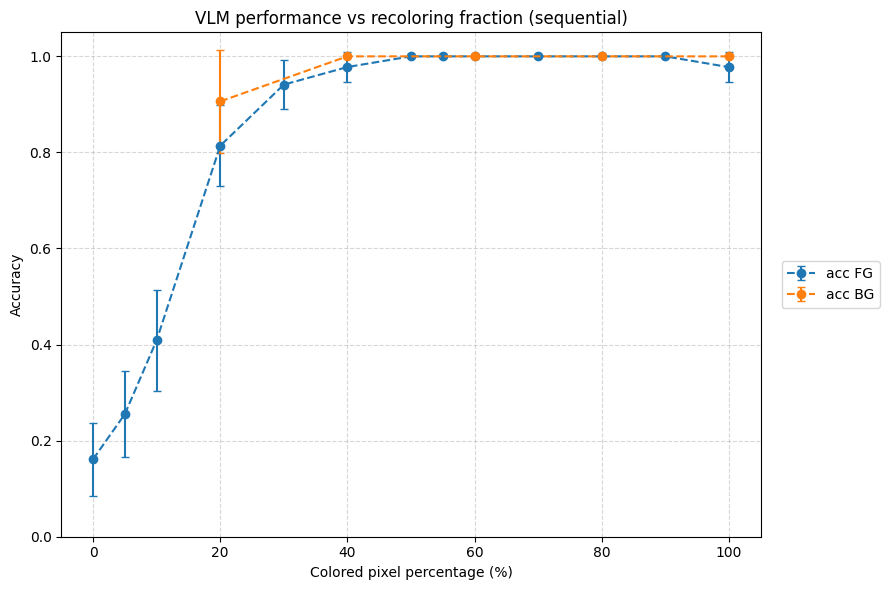

In [ ]:
gpt_shape_pred_df = pd.read_csv(GPT / "evaluation_gpt-4o_shapes.csv")
gpt_shape_pred_df = gpt_shape_pred_df.merge(shape_df, on=["image_path", "object"])
display(gpt_shape_pred_df)
plot_vlm_prolific(gpt_shape_pred_df, ci=True)

# 3. Qwen3-VL

In [ ]:
qwen_model_name = "Qwen3-VL-8B-Instruct"

qwen_processor = AutoProcessor.from_pretrained(
    "Qwen/Qwen3-VL-8B-Instruct",
    trust_remote_code=True
)

qwen_model = AutoModelForVision2Seq.from_pretrained(
    "Qwen/Qwen3-VL-8B-Instruct",
    device_map="auto",
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    quantization_config=bnb_config,
    trust_remote_code=True,
).to(device)


QWEN = DATA / "Qwen3_results"
QWEN.mkdir(parents=True, exist_ok=True)

/mnt/lustre/work/eickhoff/esx061/.conda/envs/thesis/lib/python3.11/site-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## 3.1. Introspection question (Qwen3-VL)

In [ ]:
calibration = ask_vlm_introspection_threshold(
    backend="qwen",
    processor=qwen_processor,
    model=qwen_model,
    device=device,
    model_name=qwen_model_name,
)

qwen_threshold = calibration["introspection_threshold"]
qwen_raw = calibration["introspection_raw"]
print(qwen_raw)
print(qwen_threshold)

user
for any object, x% of its pixels should be colored for it to be considered that color.
for example, imagine an image of a banana, where only part of the banana in the image is colored yellow.
at what point would you personally say that the banana in the image is yellow?
what value should x% be?
please only answer with a single number between 0 and 100.
assistant
50
50


## 3.2. Color Prior Dataset (Qwen3-VL)

In [ ]:
suffix = "image_priors"
qwen_prior_pred_df = evaluate_vlm_on_stimuli(
    prior_df,
    processor=processor,
    model=model,
    device=device,
    image_root=DATA,
    desc="Evaluating canonical object colors (correct-prior stimuli)",
)

out_path = QWEN / f"evaluation_{model_name}_{suffix}.csv"
qwen_prior_pred_df.to_csv(out_path, index=False)

## 3.3. Counterfact Color Dataset (Qwen3-VL)

In [ ]:
suffix = "counterfact"
qwen_cf_pred_df = evaluate_vlm_on_stimuli(
    counterfact_df,
    processor=processor,
    model=model,
    device=device,
    image_root=DATA,
    desc="Evaluating counterfact object colors (counterfact stimuli)",
)

out_path = QWEN / f"evaluation_{model_name}_{suffix}.csv"
qwen_cf_pred_df.to_csv(out_path, index=False)

## 3.4. Shape Dataset (Qwen3-VL)

In [ ]:
suffix = "shapes"
qwen_shape_pred_df = evaluate_vlm_on_stimuli(
    shape_df,
    processor=processor,
    model=model,
    device=device,
    image_root=DATA,
    desc="Evaluating shapes",
)

out_path = QWEN / f"evaluation_{model_name}_{suffix}.csv"
qwen_shape_pred_df.to_csv(out_path, index=False)